In [195]:
import os
import typing
import warnings

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import missingno as msno 
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt


from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [27]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

In [28]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

In [29]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [30]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Data Exploration

We have multiple houses, and we want to predict their **market price**.
So we are going to explore the features that we have.

In [263]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

In [34]:
print('Number of samples: ', train_set.shape[0])
print('Number of features: ', test_set.shape[1])

Number of samples:  5432
Number of features:  21


In [220]:
train_set.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,NaN,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,NaN,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0


In [112]:
def diplay_unique_values(df: pd.DataFrame):
    for column in train_set.columns.values:
        print(f'{column.capitalize()} - {train_set[column].dtype} - ', train_set[column].nunique())
    
diplay_unique_values(train_set)

Suburb - object -  292
Address - object -  5400
Rooms - int64 -  8
Type - object -  3
Price - float64 -  1458
Method - object -  5
Sellerg - object -  203
Date - object -  58
Distance - float64 -  194
Postcode - float64 -  187
Bedroom2 - float64 -  11
Bathroom - float64 -  9
Car - float64 -  10
Landsize - float64 -  1131
Buildingarea - float64 -  435
Yearbuilt - float64 -  121
Councilarea - object -  32
Lattitude - float64 -  3568
Longtitude - float64 -  3790
Regionname - object -  8
Propertycount - float64 -  289
Price_log - float64 -  1458


In [214]:
# In the case of the Addres, we can see that would not provide a lot of information to have such a categorical variable
train_set.drop(['Address'], axis=1, inplace=True)
test_set.drop(['Address'], axis=1, inplace=True)

In [139]:
# We can sort the values on the year of built, which will help for some visualizations
train_set = train_set.sort_values(['YearBuilt'])
test_set = test_set.sort_values(['YearBuilt'])

In [274]:
train_set.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,NaN,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0,14.137594
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,NaN,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0,13.910821
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0,14.207553
3,Brunswick,13 Percy St,3,h,1055000.0,S,Nelson,7/05/2016,5.2,3056.0,3.0,1.0,1.0,324.0,NaN,1930.0,Moreland,-37.76530,144.95860,Northern Metropolitan,11918.0,13.869051
4,Templestowe Lower,253 Thompsons Rd,4,h,1000000.0,VB,hockingstuart,13/08/2016,13.8,3107.0,4.0,3.0,2.0,728.0,164.0,1970.0,Manningham,-37.76800,145.10270,Eastern Metropolitan,5420.0,13.815511


In [117]:
# We can assess how many nulls we have from each column
nan_cols = train_set.columns[train_set.isna().any()].tolist()

for nan_col in nan_cols:
    print(f'Column {nan_col}:', train_set[nan_col].isna().sum())

Column Car: 25
Column BuildingArea: 2542
Column YearBuilt: 2130
Column CouncilArea: 553


<AxesSubplot: >

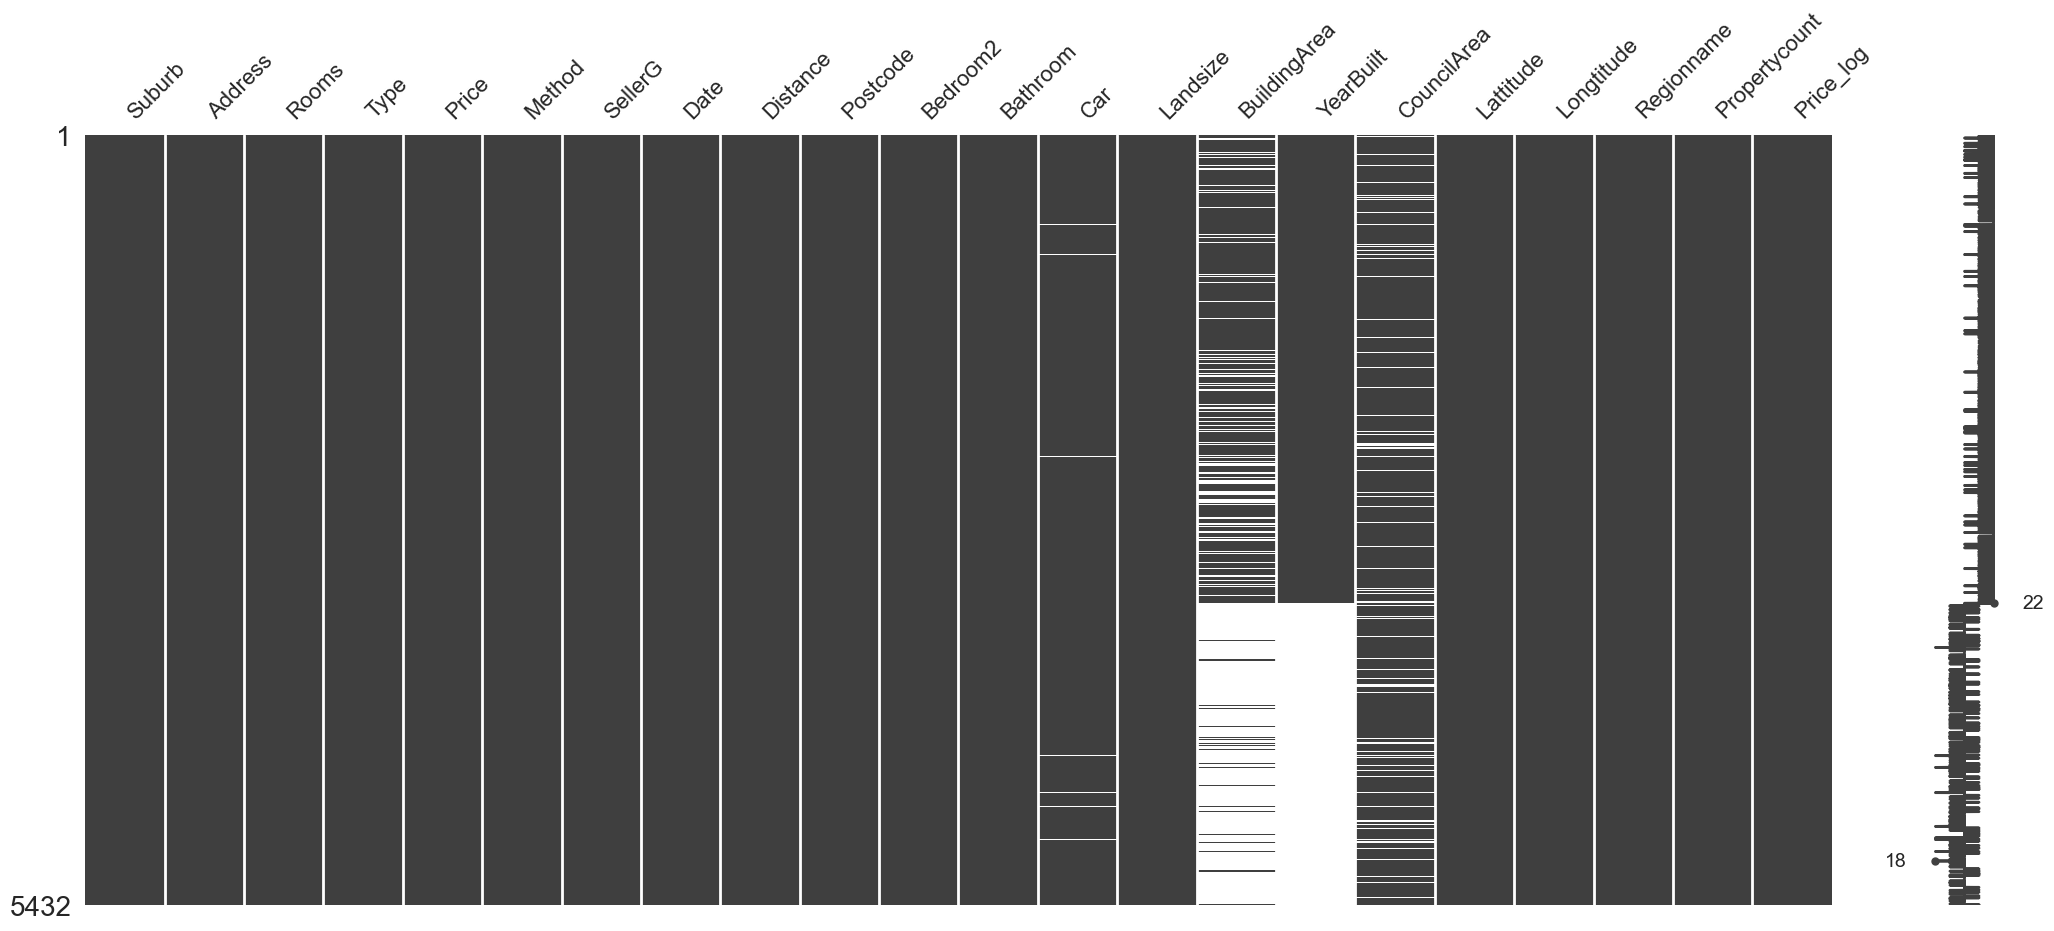

In [144]:
msno.matrix(
    train_set
)

We can see that for the null years of building, we are missing a lot of values for `BuildingArea` column.

<AxesSubplot: >

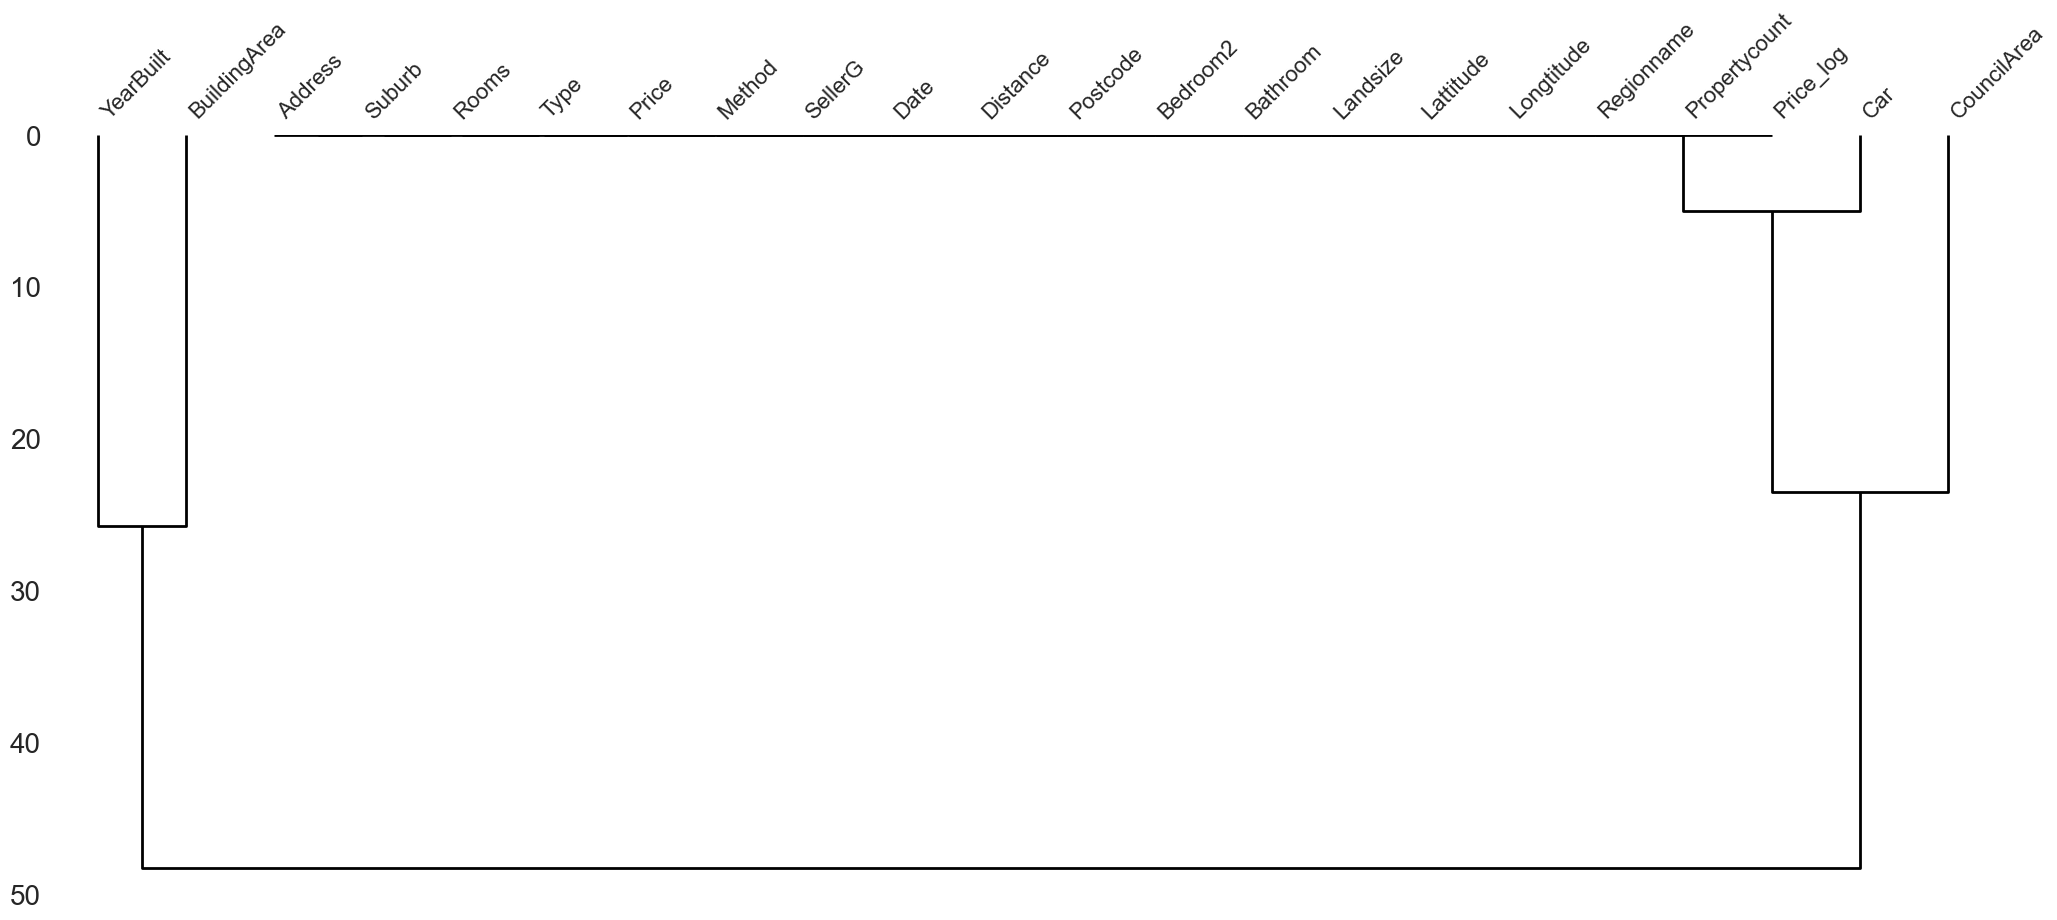

In [146]:
# We can also use a dendogram for analyzing this nullity relation
msno.dendrogram(train_set)

We can now see that we have also a bit of nullity relation between `Propertycount`, `Car`, and then with `CouncilArea`.

### Categorical Variables

In [52]:
# Can take a closer look to the object ones
train_set.select_dtypes(include=['object']).head(3)

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
index,,,,,,,,
0,Aberfeldie,241 Buckley St,h,VB,Nelson,12/08/2017,Moonee Valley,Western Metropolitan
1,Northcote,67 Charles St,h,SP,Jellis,20/05/2017,Darebin,Northern Metropolitan
2,Balwyn North,42 Maud St,h,PI,Jellis,15/10/2016,Boroondara,Southern Metropolitan


### Type

<AxesSubplot: xlabel='count', ylabel='Type'>

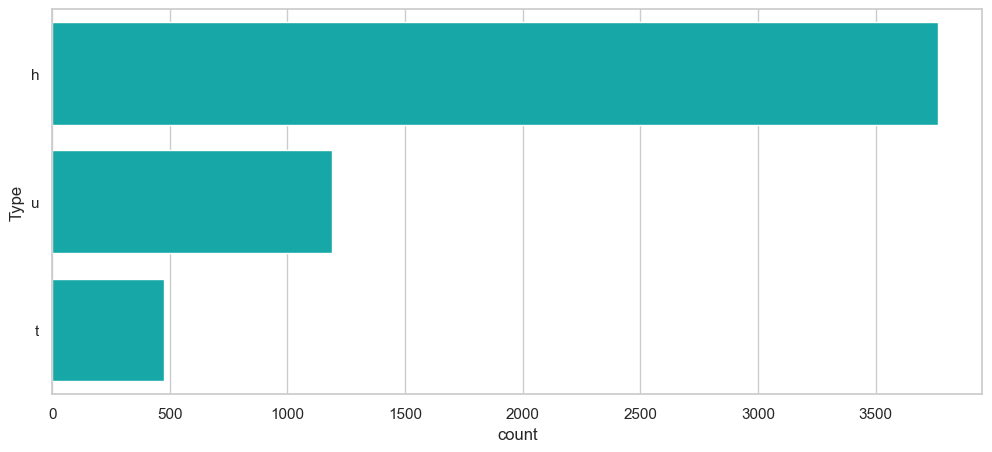

In [53]:
sns.countplot(
    y='Type',
    data=train_set,
    color='c'
)

We have the different types:
- **h**: hourse, cottage, villa, semi, terrace
- **u**: unit, duplex
- **t**: townhouse

And we can see that the majority of them are of type *h*.

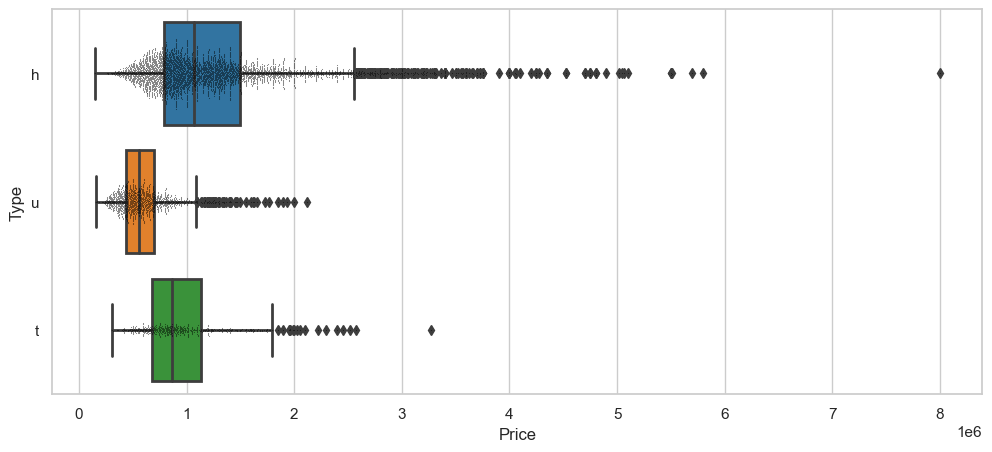

In [264]:
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can see important outliers.

Will create a function that removes the outliers grouping by certain categorical variables.

In [266]:
# We will compute the z-score for the prices of houses grouping by the region, and removing outliers (z-score > 3)
def rm_categorical_price_outlier(
    df: pd.DataFrame,
    target_col: str = 'Price',
    group_cols: typing.List[str] = ['Type', 'Method', 'Regionname'],
    bound: typing.Tuple[float, float] = (-3., 3.)
) -> typing.List[int]:
    
    all_dropped = []
    
    for group_col in group_cols:
        for group in df[group_col].unique():
            df_subset = df.loc[df[group_col] == group, target_col].to_frame()
            subset_z_score = df_subset.apply(zscore)

            # And now we drop those indices of the rows that have z-score out of bounds (-3, 3)
            to_drop = list(
                (subset_z_score[(subset_z_score > bound[1]).values].index)) + list(
                (subset_z_score[(subset_z_score < bound[0]).values].index)
            )
            all_dropped += to_drop

            df.drop(
                to_drop, 
                axis=0, 
                inplace=True
            )
    
    return df, all_dropped

In [267]:
train_set, _ = rm_categorical_price_outlier(train_set)

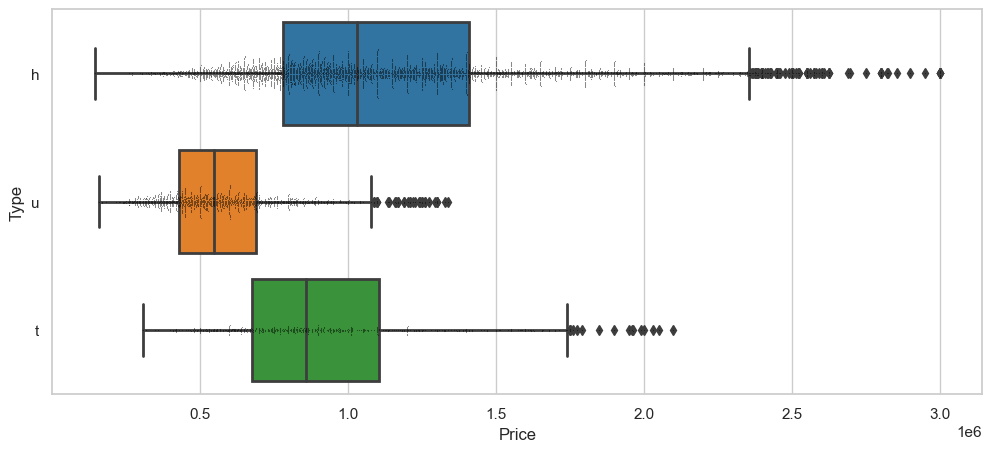

In [268]:
# And can compare with the before plot
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can make a qqplot to see if there is normality of the pricess grouping by this categorical variable.

In [345]:
def qqplot_price_category(
    df: pd.DataFrame, 
    category_group: str,
    target_col: typing.Optional[str] = 'Price',
    input_shape: typing.Optional[typing.List[int]] = [1, 3]
):
    # Consider normality of price distribution in each group to apply ANOVA 
    fig, axs = plt.subplots(input_shape[0], input_shape[1], figsize=(16, 14))

    x_row, y_col = 0, -1
    for idx, value in enumerate(df[category_group].unique()):
        x_row = x_row + 1 if idx % 3 == 0 and idx > 0 else x_row
        y_col = y_col - 2 if idx % 3 == 0 and idx > 0 else y_col + 1
        
        print(idx, x_row, y_col)

        region_set = df.loc[df[category_group].eq(value), target_col]
        
        ax = axs[x_row, y_col] if input_shape[0] > 1 else axs[idx]

        pg.qqplot(
            region_set, 
            dist='norm', 
            ax=ax
        )
        ax.set_title(value)

    plt.tight_layout()

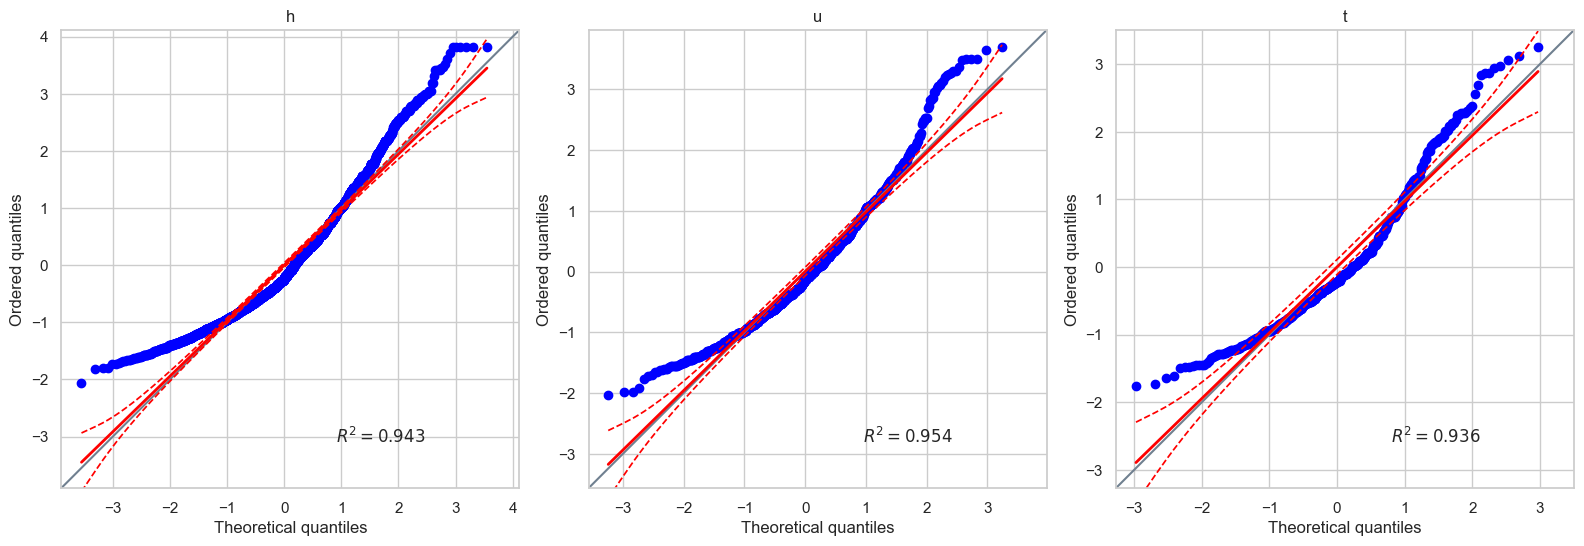

In [317]:
qqplot_price_category(
    train_set,
    category_group='Type'
)

In [277]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Type', 
    method='levene'
)

,W,pval,equal_var
levene,277.16581,4.075313e-115,False


### Region Name

Visualize a boxplot with the outliers also removed for this categorical variable.

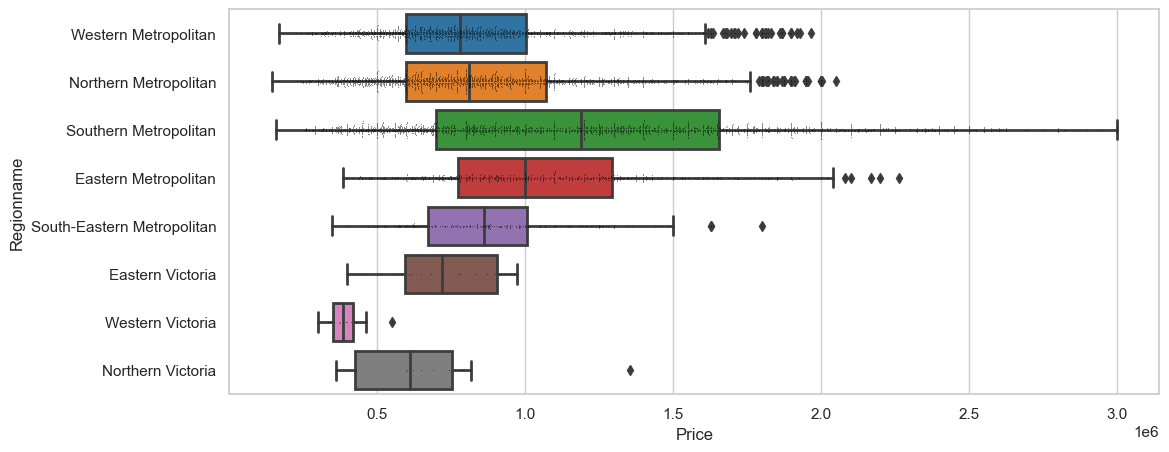

In [269]:
sns.boxplot(
    x='Price',
    y='Regionname',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Regionname", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can still see that there is a difference in the visualization on the distribution.

We might have to do a test to know if this difference of distributions is important to take into consideration. For this, we could make an ANOVA test.

0 0 0
1 0 1
2 0 2
3 1 0
4 1 1
5 1 2
6 2 0


IndexError: index 2 is out of bounds for axis 0 with size 2

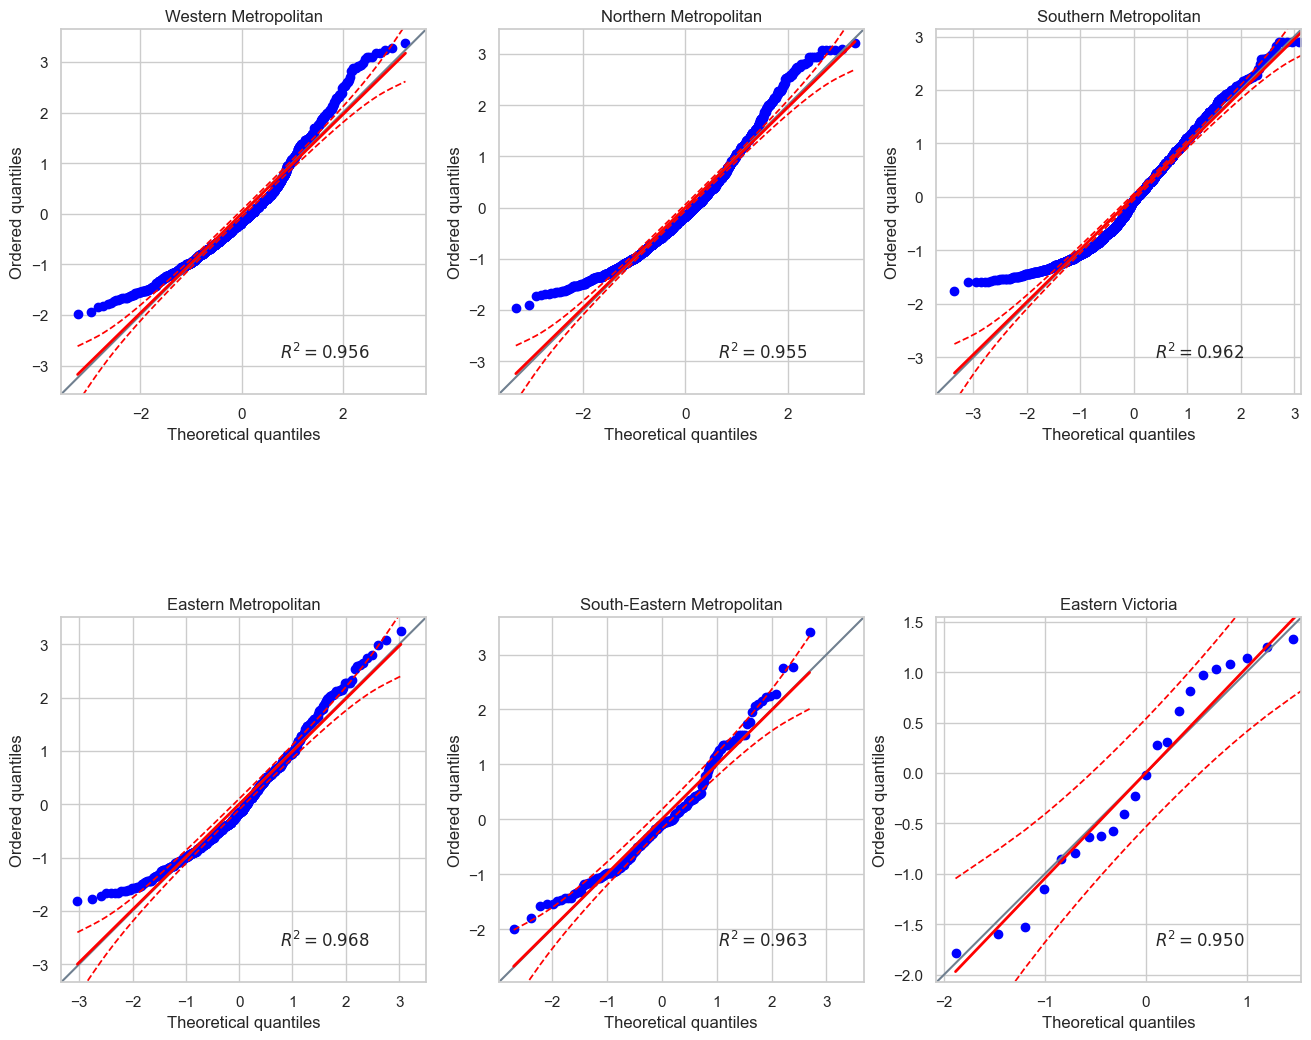

In [346]:
qqplot_price_category(
    train_set,
    category_group = 'Regionname',
    input_shape = [2, 3]
)

In [256]:
# We can also make the test Shapiro-Wilk to assess the normality
pg.normality(
    data=train_set, 
    dv='Price', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Western Metropolitan,0.965976,1.032635e-15,False
Northern Metropolitan,0.956483,8.682601e-21,False
Southern Metropolitan,0.950740,2.855992e-24,False
Eastern Metropolitan,0.969471,1.590410e-09,False
South-Eastern Metropolitan,0.966500,1.387552e-04,False
Eastern Victoria,0.929644,1.074470e-01,True
Western Victoria,0.942243,4.114184e-01,True
Northern Victoria,0.843051,1.078405e-02,False


In [276]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Regionname', 
    method='levene'
)

,W,pval,equal_var
levene,138.528882,8.198671e-188,False


So we can only say at most that we have **normal distributions** for two of the regions: Eastern & Western Victoria.

We can try to create the logarithm of the price, and try to assess again the normality of the distribution.

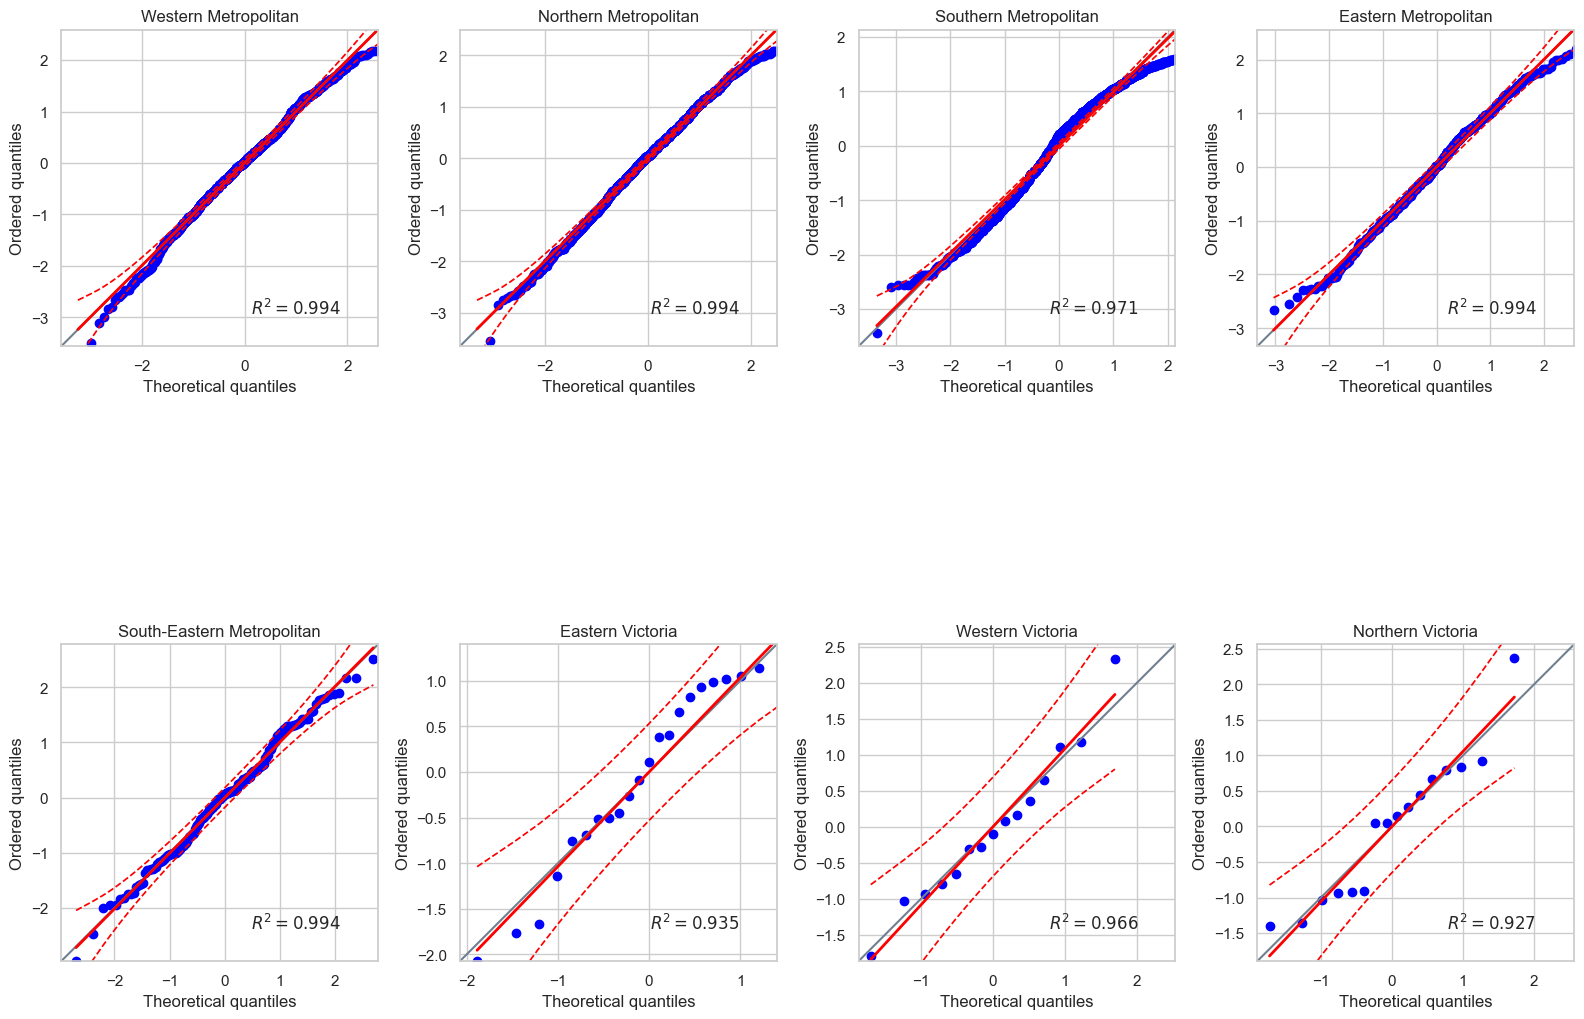

In [271]:
train_set['Price_log'] = np.log(train_set.Price)

qqplot_price_region(train_set, 'Price_log')

In [272]:
pg.normality(
    data=train_set, 
    dv='Price_log', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Western Metropolitan,0.993523,6.131901e-05,False
Northern Metropolitan,0.993486,3.441152e-06,False
Southern Metropolitan,0.970169,1.958435e-18,False
Eastern Metropolitan,0.992174,4.115439e-03,False
South-Eastern Metropolitan,0.993349,5.273652e-01,True
Eastern Victoria,0.919121,6.379469e-02,True
Western Victoria,0.975875,9.335374e-01,True
Northern Victoria,0.925994,2.104936e-01,True


It is now more like a normal distribution of the prices divided by the regions.

So we can make now an ANOVA, to assess which is the influence of the Region Name on the logarithm of the pricing.

In [273]:
pg.anova(
    data=train_set, 
    dv='Price_log', 
    between='Regionname', 
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,Regionname,125.317728,7,17.902533,85.106268,1.168594e-117,0.102684
1,Within,1095.108342,5206,0.210355,NaN,NaN,NaN


We have very small **p-value**, which means that we could reject the null hyphotesis that the means of the logarithmic prices across Region Names are the same.

### Method

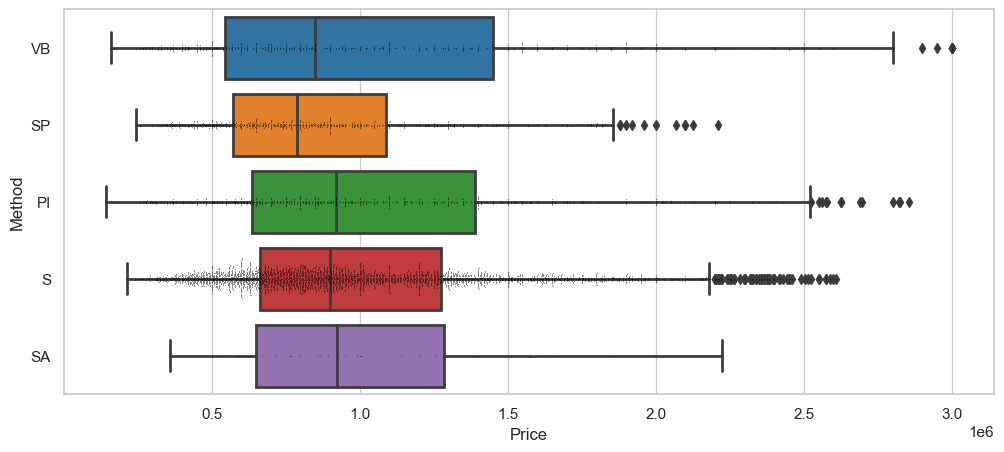

In [275]:
sns.boxplot(
    x='Price',
    y='Method',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Method", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

## Numerical Variables

To start with this, we can first compute which is the correlation between the numerical variables.

<AxesSubplot: >

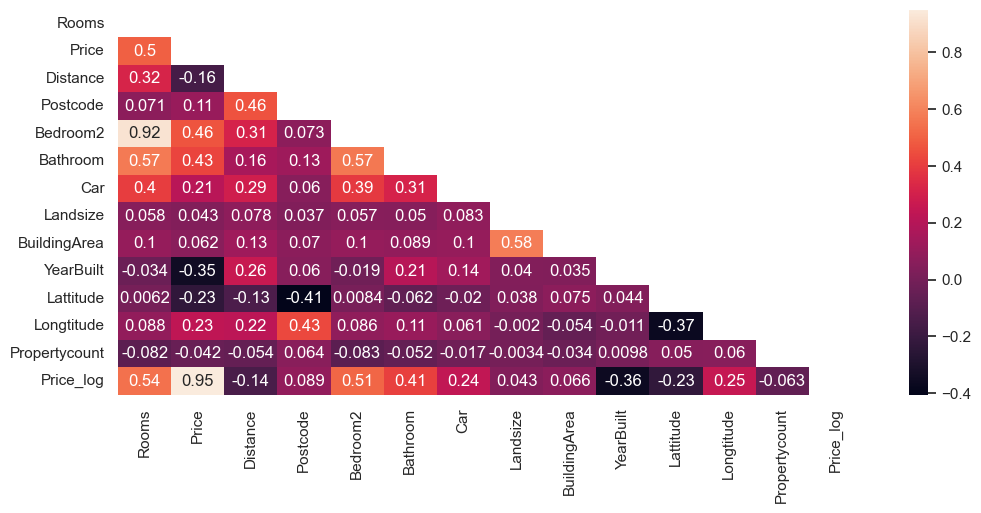

In [261]:
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

So we can see that there are some variables with more correlation with price than logarithmic price:
- **Distance**
- **Bedroom2**
- **Bathroom**

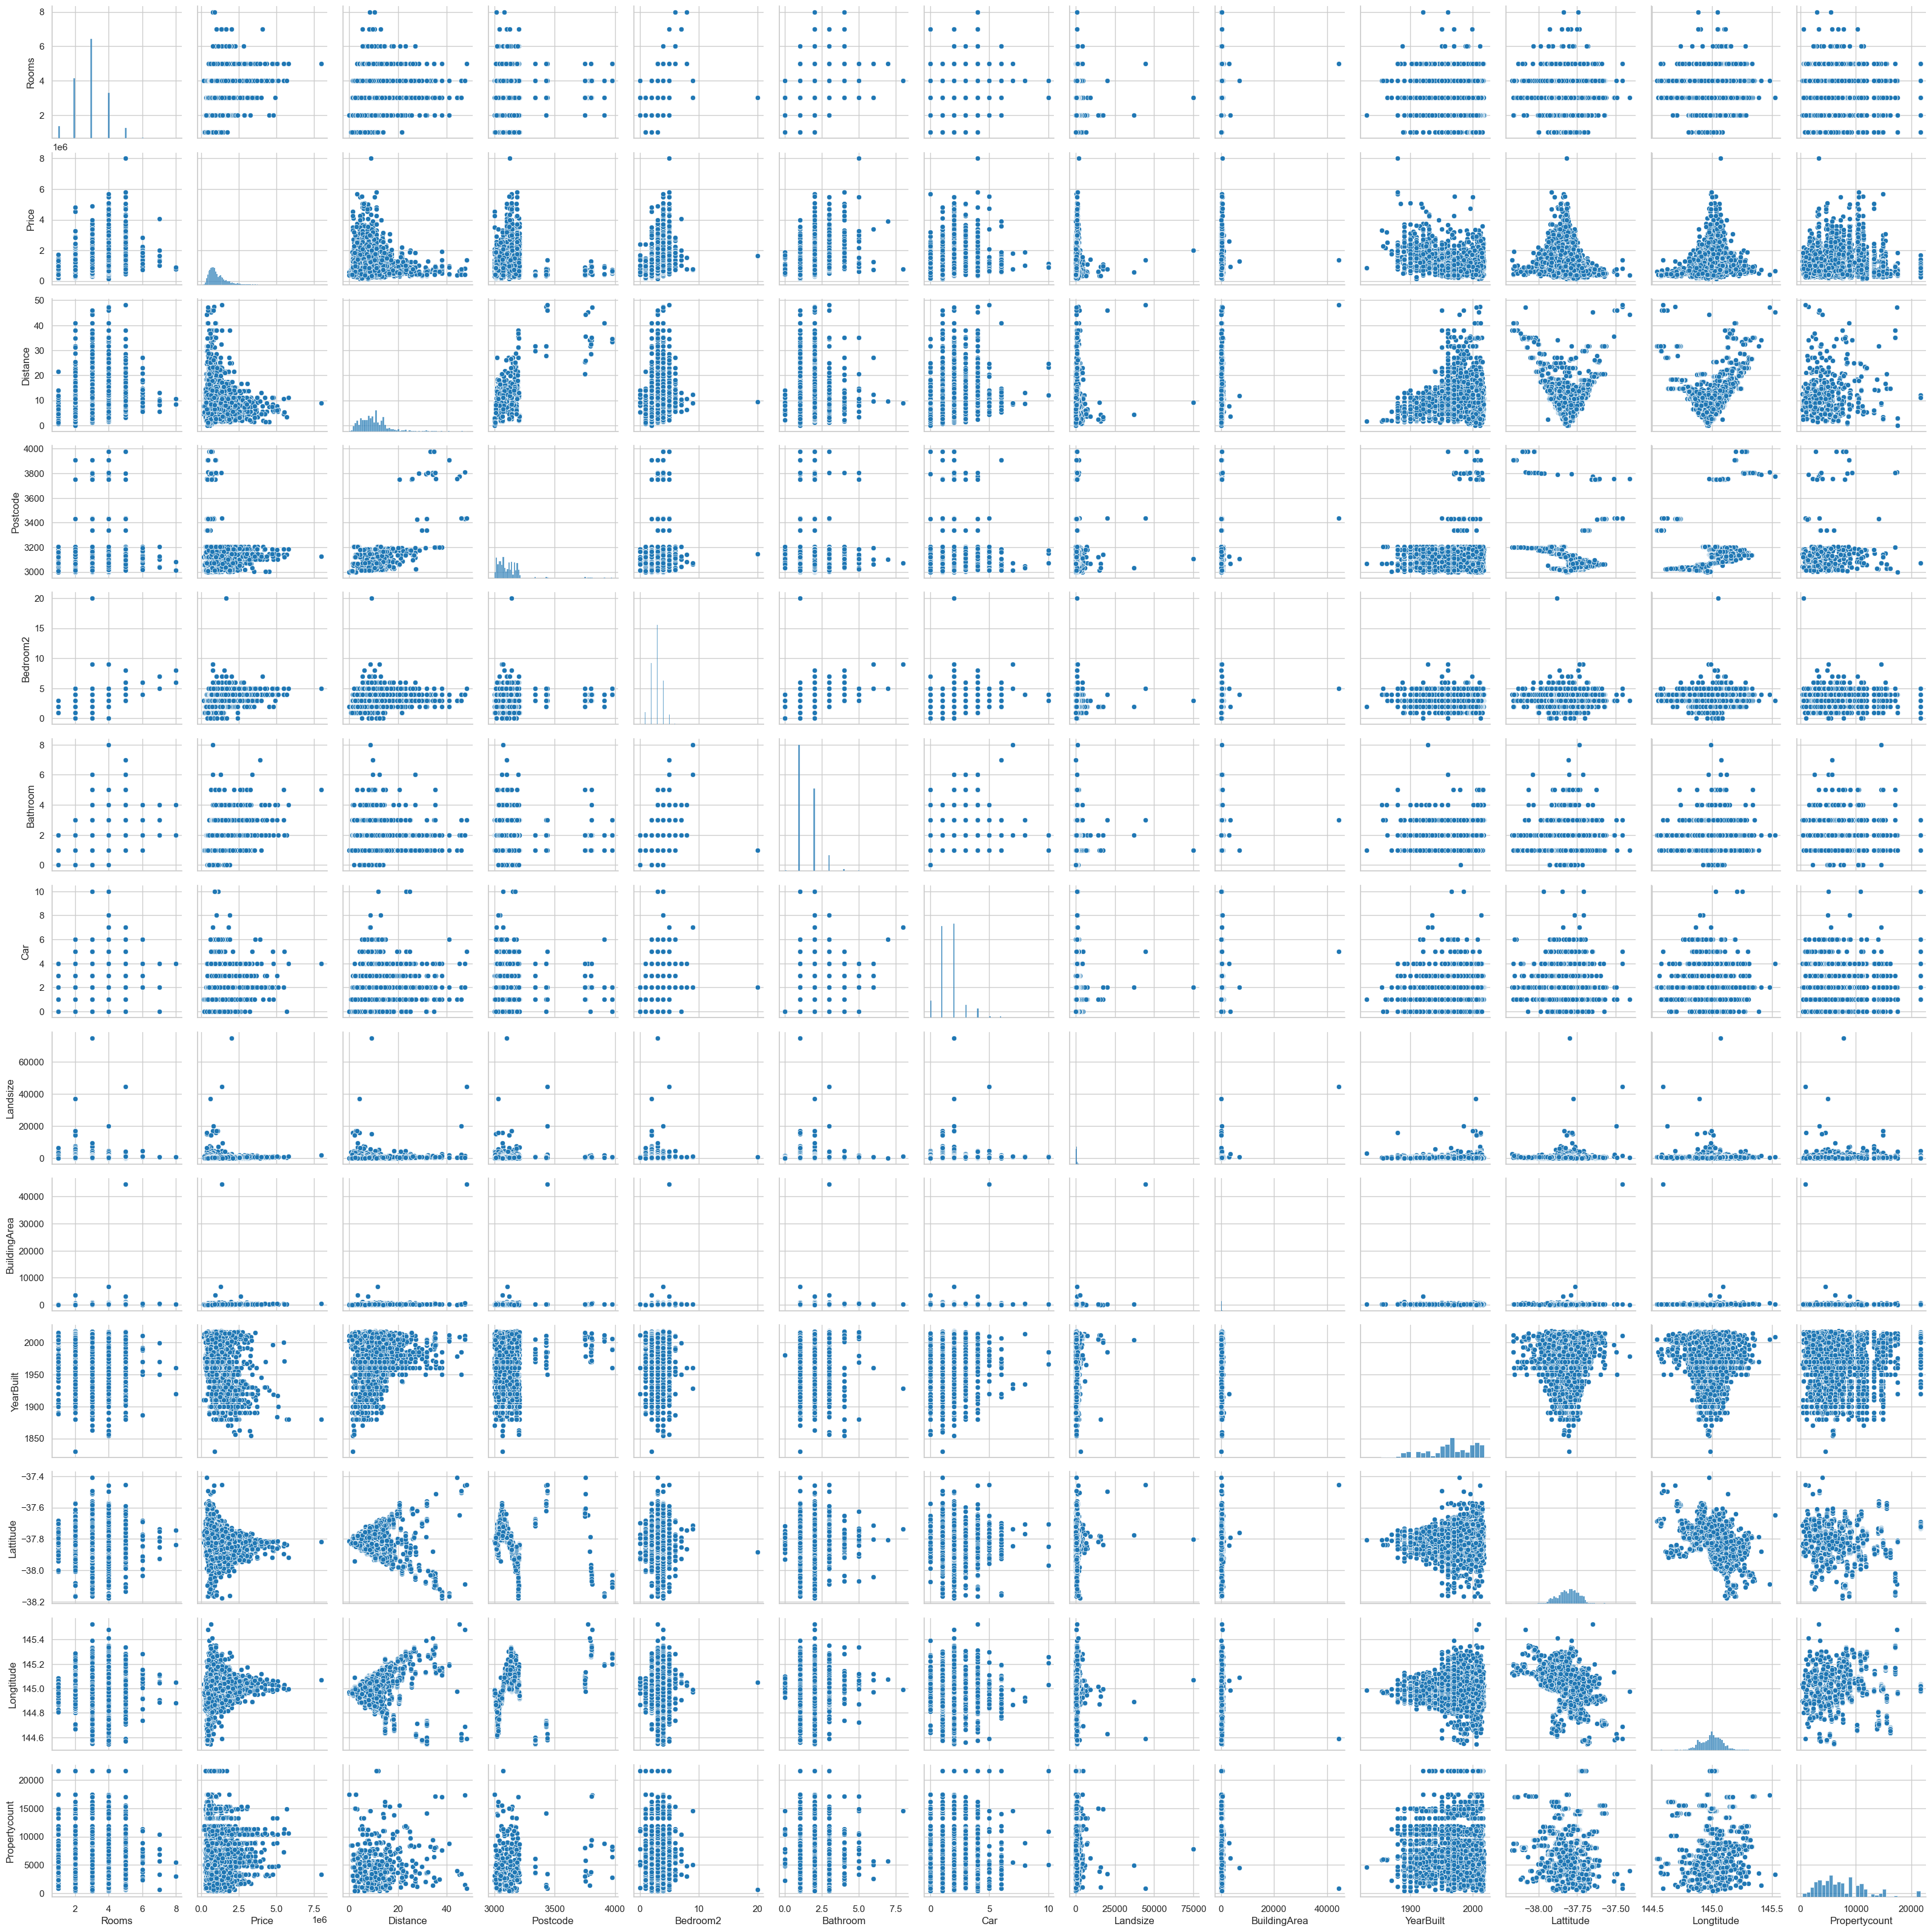

In [234]:
# We can create also pairplot so see how the distribution pairs are
sns.pairplot(
    train_set
)

# Feature Engineering

Date Feature Enginering:
- Year / Month in which it was sold

Normalization of features (for LR, in case of Trees not be necessary).

PCA.

## Model Creation

## Linear Regression

## Decision Trees

## TODO's

- With one hot encoding, the U of Type could be skipped (multi-collinearity if we have all of them)
- Create model for predicting building area / landsize & infer nan -> LR for type of house and landsize
- Buildyear based on KNN, 
- Filter by the outliers 
- Each model for division
- Train/val split
- Data with same ranges as test (and same parameters for conversion/normalization)